In [61]:
#Load data
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import arviz as az
#plt.style.use('science')
az.style.use(["science", "grid",  'tableau-colorblind10'])
%config InlineBackend.figure_format = 'retina'
import sys 
sys.path.append("../src/")
from utils.metrics import *
from utils.visual_functions import *
from datetime import datetime, timedelta
%matplotlib inline
import os
from IPython.display import clear_output
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from utils.visual_functions import *
from statsmodels.graphics.api import qqplot

nice_fonts = {
        # Use LaTeX to write all text
        "font.family": "serif",
        # Always save as 'tight'
        "savefig.bbox" : "tight",
        "savefig.pad_inches" : 0.05,
        "ytick.right" : True,
        "font.serif" : "Times New Roman",
        "mathtext.fontset" : "dejavuserif",
        "axes.labelsize": 15,
        "font.size": 15,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        # Set line widths
        "axes.linewidth" : 0.5,
        "grid.linewidth" : 0.5,
        "lines.linewidth" : 1.,
        # Remove legend frame
        "legend.frameon" :True
}
matplotlib.rcParams.update(nice_fonts)

def plot_prediction_with_pi(ax, true, mu, q_pred, date, true_max=None):
  

    h1 = ax.plot(date, true, ".", mec="#ff7f0e", mfc="None")
    h2 = ax.plot(date, mu,   '--',  c="#1f77b4", alpha=0.8)
    ax.set_ylabel('Power $(W)$')
    N = q_pred.shape[0]
    alpha = np.linspace(0.1, 0.9, N//2).tolist() + np.linspace(0.9, 0.2, 1+N//2).tolist()
    
    for i in range(N):
        y1 = q_pred[i, :]
        y2 = q_pred[-1-i, :]
        h3 = ax.fill_between(date, y1.flatten(), y2.flatten(), color="lightsteelblue", alpha=alpha[1])

    #ax.plot(date, q_pred[-1,:], 'k--')
    #ax.plot(date, q_pred[0,:], 'k--')
    ax.autoscale(tight=True)
    if true_max is None:
        true_max = true.max()+1000
        
    ax.set_ylim(true.min(), true_max)
    
    locator = mdates.HourLocator()
    ax.xaxis.set_major_locator(locator)
    
    hfmt = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(hfmt)
    
    lines =[h1[0], h2[0], h3]
    label = ["True", "Pred median", "$95\%$ Interval"]
    ax.legend(lines, label, loc=0)
    
    return ax

## Get performnce

In [64]:
#exp_name='backtesting_expanding_cross_publication_adam_with_seasonality'
exp_name ='backtesting_expanding_cross_net_load_forecasting_with_seasonality'
encoders = [ "MLPEncoder", "GRUEncoder", "UNETEncoder",'LinearHMM', 'GRUGauss',  'RF', 'SVR',   'ARNET']
enc_labels = ["FPQ-MLP", "FPQ-GRU", "FPQ-UNET", "SSM", "GRU-NORMAL", "RF", "SVR", "SARIMA", "AR-NET"]

In [63]:
# overall
encoders_results={}
encoders_spilits={}
for encoder in encoders:
    metrics_list=[]
    metrics_spilit={}
    for cross in range(1, 8):
        
       
        results=np.load(f"../results/{exp_name}/{encoder}/cross_validation_{cross}_processed_results.npy", allow_pickle=True).item()
        
        pred = results["pred"]
        q_pred = results["q_pred"] if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder", "GRUGauss", "GRUBaseline", "GRUMDN"] else None
        true =results["true"]
        tau_hat =results["tau_hat"] if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder",  "GRUGauss","GRUBaseline", "GRUMDN"] else None
        target_range = results['target_range']
        #if encoder=="LinearHMM":
        #tau_hat=torch.from_numpy(tau_hat[None, :, None]).expand_as(torch.from_numpy(q_pred)).numpy()
        samples=results["samples"] if encoder in ["LinearHMM", "GRUMDN", "GRUBaseline", "GRUGauss"] else None
        if encoder in [ "GRUMDN", "GRUBaseline", "GRUGauss"]:
            samples=np.hstack([h for h in samples.reshape(-1, 1000, 48)]).T[:,:,None].reshape(1000, -1, 1)
        #target_range = np.subtract(*np.percentile(true, [75, 25]))
        
        if cross==1 and encoder in ["LinearHMM", "MLPEncoder", "GRUEncoder", "GRUBaseline", "UNETEncoder", "GRUGauss", "GRUMDN"]:
            
            
            sample = samples[:, :96,0] if samples is not None else None
            #target_range=(true[i:i+48, 0].T).max()-(true[i:i+48, 0].T).min()
            true_nmpic=2*true.T.std()/target_range
            #true_nmpic=2*true[i:i+48, 0].T.std()/target_range
            tau = tau_hat[:96,:, 0].T
            alpha=1.0
            std = q_pred[:].std(1).flatten() if encoder not in ["LinearHMM", "GRUMDN", "GRUBaseline", "GRUGauss"] else samples[:, :, :].std(0).flatten()
            metric =get_daily_metrics(pred[:96, 0].T, true[:96, 0].T, q_pred[:96,:, 0].T, target_range, true_nmpic, sample, tau, alpha)
            fig, ax = plt.subplots(1, 1, figsize = (9,3))
            #fig, ax = plt.subplots(1, 1, figsize = set_figure_size(fig_width=6, columns=2))
            q_p = q_pred[:96, :, 0].T
            l,u = q_p[0], q_p[-1]
            ax=plot_prediction_with_pi(ax, true[:96], pred[:96], q_pred[:96, :, 0].T, results['index'][:96])
            if encoder in ["LinearHMM", "GRUMDN", "GRUBaseline", "GRUGauss"]:
                met=metric[['nrmse', 'ciwe', 'ncrps']].mean().values
            else:
                met=metric[['nrmse', 'ciwe', 'qncrps']].mean().values
                
            ax.plot(results['index'][:96], l, 'k--')
            ax.plot(results['index'][:96], u, 'k--')
            ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
            plt.yticks(fontsize=12)
            plt.xticks(fontsize=12)
            plt.ylabel("Power ($W$)", fontsize=15)
            min_y=min(true.min(), l.min(), 0)
            max_y=max(true.max(), u.max(), 60000)
            ax.set_ylim(min_y, max_y)
            fig.autofmt_xdate(rotation=90, ha='center')
            fig.tight_layout()
            fig.savefig(f"../figures/{exp_name}/{encoder}_confidence.pdf", dpi=480)
            plt.close()
            
            
            
            
            
            fig, ax = plt.subplots(1,1, figsize=(5.5,3))
            ax=plot_calibration(ax, pred[:], std, true[:])
            fig.tight_layout()
            fig.savefig(f"../figures/{exp_name}/{encoder}_calibration.pdf", dpi=480)
            plt.close()
            fig, ax = plt.subplots(1,1, figsize=(5.5,3))
            ax=plot_intervals_ordered(ax, pred[:], std, true[:96])
            fig.tight_layout()
            fig.savefig(f"../figures/{exp_name}/{encoder}_interval.pdf", dpi=480)
            plt.close()
            
            
            
            
        
        metrics=[]
        
            
        #samples[:, i:i+48,0]
        for i in range(0, len(pred), 48):
            if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder", "GRUMDN", "GRUGauss", "GRUBaseline"]:
                sample = samples[:, i:i+48,0] if samples is not None else None
                sample = None
                #target_range=(true[i:i+48, 0].T).max()-(true[i:i+48, 0].T).min()
                true_nmpic=2*true.T.std()/target_range
                #true_nmpic=2*true[i:i+48, 0].T.std()/target_range
                tau = tau_hat[i:i+48,:, 0].T
                alpha=1.0
                metric =get_daily_metrics(pred[i:i+48, 0].T, true[i:i+48, 0].T, q_pred[i:i+48,:, 0].T, target_range, true_nmpic, sample, tau, alpha)
                
            else:
                metric=  get_daily_pointwise_metrics(pred[i:i+48, 0].T, true[i:i+48, 0].T, target_range)
                
                
            metrics.append(metric)
                #print(index[i:i+48][0])
        metrics = pd.concat(metrics)
        metrics_list.append(pd.DataFrame(metrics.mean()).T)
        metrics_spilit[cross] = metrics
        
    pd_metrics = pd.concat(metrics_list)
    
    
    print('...........................................................................................')
    print('')
    print(f'Results for {encoder}')
    
    print('...........................................................................................')
    if encoder not in ['RF', 'SVR', 'ARNET', 'SARIMAX']:
        
        if encoder  in ['LinearHMM', 'GRUMDN', "GRUBaseline", "GRUGauss"]:
            print("MAE,  NRMSE,    NCRSP,   PIC,  NMPI, CWE,   CORR  ")
            print(f"{pd_metrics['mae'].mean():.{2}f} $\pm$ {pd_metrics['mae'].std():.{2}f} & \
            {pd_metrics['nrmse'].mean():.{2}f} $\pm$ {pd_metrics['nrmse'].std():.{2}f} & \
            {pd_metrics['ncrps'].mean()/1000:.{2}f} $\pm$ {pd_metrics['ncrps'].std()/1000:.{2}f} & \
             {pd_metrics['pic'].mean():.{2}f} $\pm$ {pd_metrics['pic'].std():.{2}f} & \
            {pd_metrics['nmpi'].mean():.{2}f} $\pm$ {pd_metrics['nmpi'].std():.{2}f}& \
            {pd_metrics['ciwe'].mean():.{2}f} $\pm$ {pd_metrics['ciwe'].std():.{2}f}& \
            {pd_metrics['corr'].mean():.{2}f} $\pm$ {pd_metrics['corr'].std():.{2}f} \\")
        else:
            print(f"{pd_metrics['mae'].mean():.{2}f} $\pm$ {pd_metrics['mae'].std():.{2}f} & \
            {pd_metrics['nrmse'].mean():.{2}f} $\pm$ {pd_metrics['nrmse'].std():.{2}f} & \
            {pd_metrics['qncrps'].mean()/1000:.{2}f} $\pm$ {pd_metrics['qncrps'].std()/1000:.{2}f} & \
             {pd_metrics['pic'].mean():.{2}f} $\pm$ {pd_metrics['pic'].std():.{2}f} & \
            {pd_metrics['nmpi'].mean():.{2}f} $\pm$ {pd_metrics['nmpi'].std():.{2}f}& \
            {pd_metrics['ciwe'].mean():.{2}f} $\pm$ {pd_metrics['ciwe'].std():.{2}f}& \
             {pd_metrics['corr'].mean():.{2}f} $\pm$ {pd_metrics['corr'].std():.{2}f} \\")
        
    else:
        print("MAE",   "NRMSE",  "SMAPE", "CORR")
        print(f"{pd_metrics['mae'].mean():.{2}f} $\pm$ {pd_metrics['mae'].std():.{2}f}& \
        {pd_metrics['nrmse'].mean():.{2}f} $\pm$ {pd_metrics['nrmse'].std():.{2}f}& \
        -&\
        -&\
        -&\
        -&\
        {pd_metrics['corr'].mean():.{2}f} $\pm$ {pd_metrics['corr'].std():.{2}f} \\")
        
    encoders_results[encoder]=pd_metrics
    encoders_spilits[encoder]=metrics_spilit
    print('') 

...........................................................................................

Results for MLPEncoder
...........................................................................................
3.35 $\pm$ 0.16 &             0.07 $\pm$ 0.01 &             2.23 $\pm$ 0.10 &              0.91 $\pm$ 0.01 &             0.25 $\pm$ 0.03&             0.74 $\pm$ 0.02&              0.92 $\pm$ 0.01 \

...........................................................................................

Results for GRUEncoder
...........................................................................................
3.57 $\pm$ 0.18 &             0.08 $\pm$ 0.01 &             2.30 $\pm$ 0.15 &              0.87 $\pm$ 0.03 &             0.23 $\pm$ 0.03&             0.70 $\pm$ 0.04&              0.92 $\pm$ 0.01 \

...........................................................................................

Results for UNETEncoder
.....................................................................

...........................................................................................

Results for Ensemble
3.88 $\pm$ 1.01 &             0.08 $\pm$ 0.02 &             2.16 $\pm$ 0.11 &              0.91 $\pm$ 0.02 &             0.24 $\pm$ 0.03&             0.74 $\pm$ 0.03&              0.92 $\pm$ 0.02 \


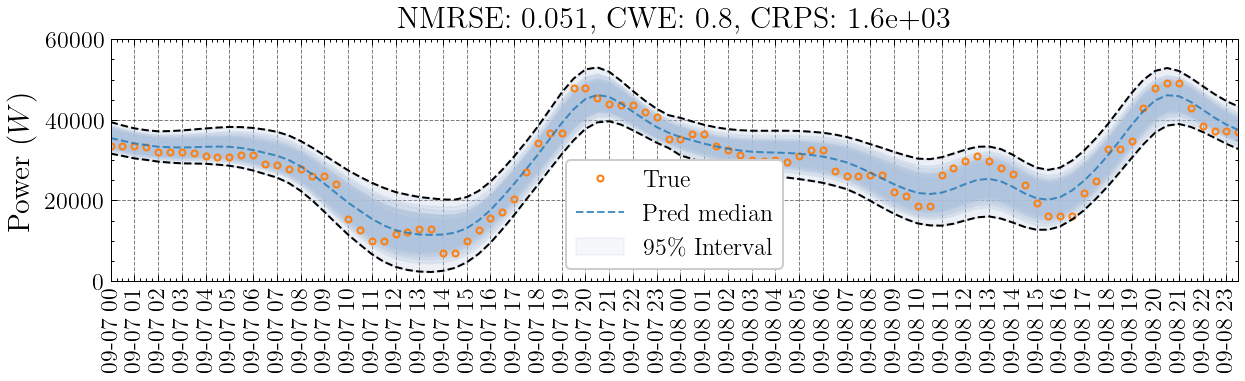

In [5]:
#
for cross in range(1, 8):
    pred_list=[]
    q_pred_list=[]
    tau_hat_list=[]
    for encoder in encoders[:3]:  
        
        results=np.load(f"../results/{exp_name}/{encoder}/cross_validation_{cross}_processed_results.npy", allow_pickle=True).item()
        pred = results["pred"]
        q_pred = results["q_pred"] if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder", "GRUGauss", "GRUBaseline", "GRUMDN"] else None
        true =results["true"]
        tau_hat =results["tau_hat"] if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder",  "GRUGauss","GRUBaseline", "GRUMDN"] else None
        target_range = results['target_range']
        
        tau_hat_list.append(tau_hat[None, :, :])
        q_pred_list.append(q_pred[None, :, :])
        pred_list.append(pred[None, :])
    tau_hat = np.concatenate(tau_hat_list).mean(0)
    pred = np.concatenate(pred_list).mean(0)
    q_pred = np.concatenate(q_pred_list).mean(0)
    
    if cross==1 and encoder in ["LinearHMM", "MLPEncoder", "GRUEncoder", "GRUBaseline", "UNETEncoder", "GRUGauss", "GRUMDN"]:
            
            
        sample = samples[:, 0:96,0] if samples is not None else None
        #target_range=(true[i:i+48, 0].T).max()-(true[i:i+48, 0].T).min()
        true_nmpic=2*true.T.std()/target_range
        #true_nmpic=2*true[i:i+48, 0].T.std()/target_range
        tau = tau_hat[0:96,:, 0].T
        alpha=1.0
        std = q_pred[:].std(1).flatten() if encoder not in ["LinearHMM", "GRUMDN", "GRUBaseline", "GRUGauss"] else samples[:, :, :].std(0).flatten()
        metric =get_daily_metrics(pred[0:96, 0].T, true[0:96, 0].T, q_pred[0:96,:, 0].T, target_range, true_nmpic, sample, tau, alpha)
        fig, ax = plt.subplots(1, 1, figsize = (9,3))

        q_p = q_pred[0:96, :, 0].T
        l,l_25, u, u_75 = q_p[0], q_p[int(82*0.1)],  q_p[-1], q_p[int(82*0.965)]
        ax=plot_prediction_with_pi(ax, true[0:96], pred[0:96], q_pred[0:96, :, 0].T, results['index'][0:96])
        if encoder in ["LinearHMM", "GRUMDN", "GRUBaseline", "GRUGauss"]:
            met=metric[['nrmse', 'ciwe', 'ncrps']].mean().values
        else:
            met=metric[['nrmse', 'ciwe', 'qncrps']].mean().values

        ax.plot(results['index'][0:96], l, 'k--')
        ax.plot(results['index'][0:96], u, 'k--')
        ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2]), fontsize=15); 
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        plt.ylabel("Power ($W$)", fontsize=15)
        min_y=min(true.min(), l.min(), 0)
        max_y=max(true.max(), u.max(), 60000)
        ax.set_ylim(min_y, max_y)
        fig.autofmt_xdate(rotation=90, ha='center')
        fig.tight_layout()
        fig.savefig(f"../figures/{exp_name}/FRSEQEnsemble_confidence.pdf", dpi=480)
        
        
    metrics=[]
    for i in range(0, len(pred), 48):
        if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder", "GRUMDN", "GRUGauss", "GRUBaseline"]:
            sample = samples[:, i:i+48,0] if samples is not None else None
            true_nmpic=2*true.T.std()/target_range
                
            tau = tau_hat[i:i+48,:, 0].T
            alpha=1.0
            metric =get_daily_metrics(pred[i:i+48, 0].T, true[i:i+48, 0].T, q_pred[i:i+48,:, 0].T, target_range, true_nmpic, sample, tau, alpha)
                
        else:
            metric=  get_daily_pointwise_metrics(pred[i:i+48, 0].T, true[i:i+48, 0].T, target_range)
                
                
        metrics.append(metric)
        
    metrics = pd.concat(metrics)
    metrics_list.append(pd.DataFrame(metrics.mean()).T)
    metrics_spilit[cross] = metrics
        
pd_metrics = pd.concat(metrics_list)
    
    
print('...........................................................................................')
print('')
print(f'Results for Ensemble')
print(f"{pd_metrics['mae'].mean():.{2}f} $\pm$ {pd_metrics['mae'].std():.{2}f} & \
            {pd_metrics['nrmse'].mean():.{2}f} $\pm$ {pd_metrics['nrmse'].std():.{2}f} & \
            {pd_metrics['qncrps'].mean()/1000:.{2}f} $\pm$ {pd_metrics['qncrps'].std()/1000:.{2}f} & \
             {pd_metrics['pic'].mean():.{2}f} $\pm$ {pd_metrics['pic'].std():.{2}f} & \
            {pd_metrics['nmpi'].mean():.{2}f} $\pm$ {pd_metrics['nmpi'].std():.{2}f}& \
            {pd_metrics['ciwe'].mean():.{2}f} $\pm$ {pd_metrics['ciwe'].std():.{2}f}& \
             {pd_metrics['corr'].mean():.{2}f} $\pm$ {pd_metrics['corr'].std():.{2}f} \\")
            
            

## Training time

In [ ]:
data_spilit={}
for i, encoder in enumerate(encoders):
    train_time_list=[]
    for cross in range(1, 8):
        results=np.load(f"../results/{exp_name}/{encoder}/cross_validation_{cross}_processed_results.npy", allow_pickle=True).item()
        
        train_time_list.append(pd.DataFrame(results['metrics'][['train_time', 'test_time']].mean()).T)
    train_time_list = pd.concat(train_time_list)
    train_time_list['spilit']=["Split-"+str(i+1) for i in range(7)]
    data_spilit[enc_labels[i]]=train_time_list
        

In [ ]:
def get_per_spilit_dataframe(split_data, metric='train_time', mean=True):
    df= pd.DataFrame()
    for key, values in split_data.items():
        if key =="GRU-MCDN":
            continue

        df[key]=values[metric]
        
    df['spilit']=["Split-"+str(i+1) for i in range(len(values))]
    return df

In [ ]:
labels=["FPQ-MLP", "FPQ-GRU", "FPQ-UNET", "SSM", "GRU-MDN", "GRU-NORMAL", "RF", "SVR", "SARIMA", "AR-NET"]
df_train=get_per_spilit_dataframe(data_spilit, metric='train_time', mean=True)
fig, ax = plt.subplots(1, 1, figsize=(12,4))
df_train.plot(kind='bar', ax=ax, x='spilit', y=labels, rot=0)
ax.set_ylabel('Train time (ms)')
ax.set_xlabel('cross-validation')
leg = ax.legend( ncol=5)

In [ ]:
labels=["FPQ-MLP", "FPQ-GRU", "FPQ-UNET", "SSM", "GRU-MDN", "GRU-NORMAL", "RF", "SVR", "SARIMA", "AR-NET"]
df_train=get_per_spilit_dataframe(data_spilit, metric='test_time', mean=True)
fig, ax = plt.subplots(1, 1, figsize=(12,4))
df_train.plot(kind='bar', ax=ax, x='spilit', y=labels, rot=0)
ax.set_ylabel('Test time (second)')
ax.set_xlabel('cross-validation')
leg = ax.legend( ncol=5)

## Visuakize Results

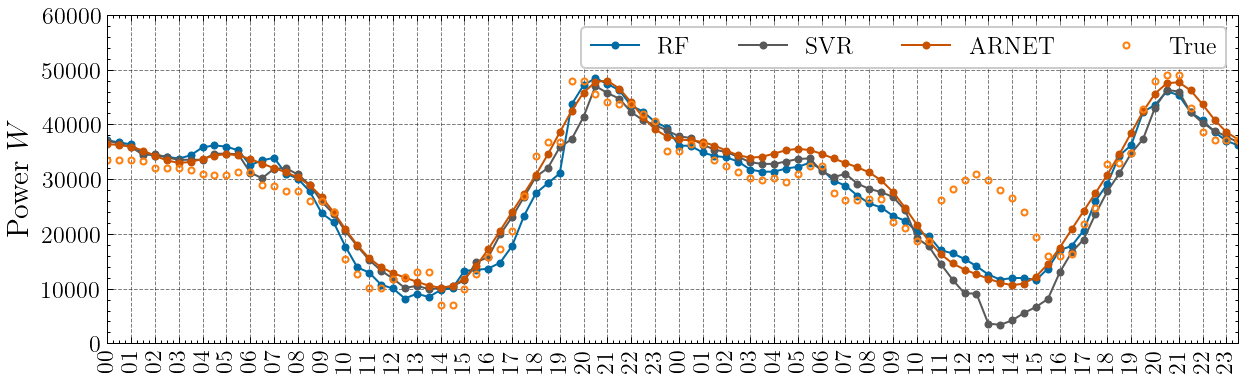

In [75]:
#visualise point forecasting
fig, ax = plt.subplots(1, 1, figsize = (9,3))
az.style.use(["science", "grid", 'tableau-colorblind10'])
colors = ['C0', 'C3', 'C5']
for i, encoder in enumerate(['RF', 'SVR',   'ARNET']):
    cross = 1

    results=np.load(f"../results/{exp_name}/{encoder}/cross_validation_{cross}_processed_results.npy", allow_pickle=True).item()

    pred = results["pred"]
    true =results["true"]
    
    index = results['index']
    ax.plot(index[0:96], pred[0:96], ".-", color=colors[i], label=encoder)
ax.plot(index[0:96], true[0:96], ".", mec="#ff7f0e", mfc="None", label="True")
ax.legend(ncol=5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
min_y=min(true.min(), pred.min(), 0)
max_y=max(true.max(), pred.max(), 60000)
ax.set_ylim(min_y, max_y)
ax.autoscale(tight=True)
plt.ylabel("Power $W$")
locator = mdates.HourLocator()
ax.xaxis.set_major_locator(locator)

hfmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(hfmt)
ax.set_ylim(min_y, max_y)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}/combined_baseline_confidence.pdf", dpi=480)

In [ ]:
#function for visualition
def per_encoder_score(dict_results, encoders, metric):
    
    df = []
    for enc in encoders:
        df.append(encoders_results[enc][[metric]].values)
        
    df = pd.DataFrame(np.hstack(df), columns=encoders)
    return df

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color="C3")
    plt.setp(bp['medians'], color="C3")
    
def grouped_boxplot(ax, df1, df2, lengends, x_labels=None):
    
    labels = list(df1.columns)
    data1=[df1[label].values.tolist() for label in labels]
    data2=[df2[label].values.tolist() for label in labels]
    pos=np.arange(len(data1))
    #bb3=plt.boxplot(data3, positions=pos*2.0+1.0, showmeans=True, manage_ticks=True, autorange=True, sym='', widths=0.6)
    bb1=ax.boxplot(data1, positions=pos*2.0-0.4, showmeans=True, manage_ticks=True, autorange=True, sym='', widths=0.6)
    bb2=ax.boxplot(data2, positions=pos*2.0+0.4, showmeans=True, manage_ticks=True, autorange=True, sym='', widths=0.6)

    set_box_color(bb1, 'C6') # colors are from http://colorbrewer2.org/
    set_box_color(bb2, 'C8')

    ax.plot([], c='C6', label=lengends[0])
    ax.plot([], c='C8', label=lengends[1])
    ax.legend()
    if x_labels:
        plt.xticks(np.arange(0, len(labels)*2, 2), x_labels, rotation=0, fontsize=12);
    else:
        plt.xticks(np.arange(0, len(labels)*2, 2), labels, rotation=0, fontsize=12);
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    ax.set_ylabel('score')
    ax.autoscale()
    return ax


In [ ]:
#encoders = [ 'LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder",  'ARNET',  'RF', 'SVR' ]
encoders = [ 'LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder", "GRUMDN", 'ARNET',  'RF', 'SVR' ]
enc_labels = ["SSM", "FPQ-MLP", "FPQ-GRU", "FPQ-UNET", "RNN-MDN", "AR-NET", "RF", "SVR"]
df_mae=per_encoder_score(encoders_results, encoders, 'mae')
df_mae_prob=per_encoder_score(encoders_results, encoders[:-3], 'mae')
df_mape=per_encoder_score(encoders_results, encoders[:-3], 'maape')
df_cwie=per_encoder_score(encoders_results,encoders[:-3], 'ciwe')
df_cwf=per_encoder_score(encoders_results, encoders[:-3], 'ciwf')
df_cwfq=per_encoder_score(encoders_results, encoders[:-3], 'ciwfq')
df_ncrps=per_encoder_score(encoders_results,encoders[:-3], 'ncrps')
df_qncrps=per_encoder_score(encoders_results,encoders[:-3], 'qncrps')
df_nll=per_encoder_score(encoders_results,encoders[:-3], 'nll')
df_pic=per_encoder_score(encoders_results,encoders[:-3], 'pic')
df_nmpi=per_encoder_score(encoders_results,encoders[:-3], 'nmpi')
df_sharp=per_encoder_score(encoders_results, encoders[:-3], 'sharpness')
df_corr=per_encoder_score(encoders_results, encoders, 'corr')
df_corr_prob=per_encoder_score(encoders_results,  encoders[:-3], 'corr')
df_nmrse=per_encoder_score(encoders_results, encoders, 'nrmse')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
ax=grouped_boxplot(ax, df_ncrps, df_qncrps, ['NCRPS', "NPCRPS"], enc_labels[:-3])
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}/pic_nmpi.pdf", dpi=480)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
ax=grouped_boxplot(ax, df_corr_prob, df_pic, ['Cov', "PIC"], enc_labels[:-3])
fig.tight_layout()
ax.set_ylim([0.8,1])
fig.savefig(f"../figures/{exp_name}/cov_pic.pdf", dpi=480)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
ax=grouped_boxplot(ax, df_corr_prob, df_pic, ['Cov', "PIC"], enc_labels[:-3])
fig.tight_layout()
ax.set_ylim([0.8,1])
fig.savefig(f"../figures/{exp_name}/cov_pic.pdf", dpi=480)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
ax=grouped_boxplot(ax, df_ncrps, df_qncrps, ['NCRSP', "QNCRSP"], enc_labels[:-3])
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}/cwe_cwf.pdf", dpi=480)

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (9, 2.5))
ax.boxplot(df_corr, showmeans=True, manage_ticks=True, autorange=True)
ax.set_ylim(0,1)
plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("Cov")
ax.autoscale(tight=True)
fig.savefig(f"../figures/{exp_name}/corr.pdf", dpi=480)

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (9, 2.5))
plt.ylim(0,1)
bp=ax.boxplot(df_nmrse, showmeans=True, manage_ticks=True, autorange=True, sym='')

plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("NMRSE")
ax.autoscale(tight=True)
ax.margins(y=0.05)
yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
eps = 0.05
ymin, ymax = yval.min()-eps, yval.max()+eps
ax.set_ylim([0,ymax])
fig.savefig(f"../figures/{exp_name}/NMRSE.pdf", dpi=480)

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (9, 2.5))
plt.ylim(0,1)
bp=ax.boxplot(df_mae, showmeans=True, manage_ticks=True, autorange=True, sym='')

plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("MAE")
ax.autoscale(tight=True)
ax.margins(y=0.05)
yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
eps = 1
ymin, ymax = yval.min()-eps, yval.max()+eps
ax.set_ylim([0,ymax])
fig.savefig(f"../figures/{exp_name}/mae.pdf", dpi=480)

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (9, 2.5))
bp=ax.boxplot(df_ncrps, showmeans=True, manage_ticks=True, autorange=True)
plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("NCRPS")
ax.autoscale(tight=True)
ax.margins(y=0.05)
yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
eps = 0.1
ymin, ymax = yval.min()-eps, yval.max()+eps
ax.set_ylim([0.0,ymax])
fig.savefig(f"../figures/{exp_name}/NCRPS.pdf", dpi=480)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
bp=ax.boxplot(df_nmpi, showmeans=True, manage_ticks=True, autorange=True)
plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("NMPI")
ax.autoscale(tight=True)
ax.margins(y=0.05)
yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
eps = 0.1
ymin, ymax = yval.min()-eps, yval.max()+eps
ax.set_ylim([0.0,ymax])
fig.savefig(f"../figures/{exp_name}/NMPI.pdf", dpi=480)

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
bp=ax.boxplot(df_cwie, showmeans=True, manage_ticks=True, autorange=True)
plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("nmpi")
ax.autoscale(tight=True)
ax.margins(y=0.05)
yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
eps = 0.1
ymin, ymax = yval.min()-eps, yval.max()+eps
#ax.set_ylim([0.5,ymax])
fig.savefig(f"../figures/{exp_name}/NLL.pdf", dpi=480)

In [ ]:
labels = ["SSM", "FPQ-MLP", "FPQ-GRU", "FPQ-UNET", "AR-NET", "RF", "SVR"]
fig, ax = plt.subplots(1,1, figsize = (7, 2.5))
ax.boxplot(df_qncrps, showmeans=True, manage_ticks=True, autorange=True)
plt.xticks(range(1, len(enc_labels )+1), enc_labels, rotation=0, fontsize=12);
ax.set_ylabel("sharpnes")
ax.autoscale(tight=True)
ax.margins(y=0.05)
yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
eps = 0.01
ymin, ymax = yval.min()-eps, yval.max()+eps
#ax.set_ylim([0.0,ymax])
fig.savefig(f"../figures/{exp_name}/SHARP.pdf", dpi=480)

In [ ]:
x_labels = ["Split-"+str(i+1) for i in range(8-1)]
fig, ax = plt.subplots(1,1, figsize=(9,3))
ax=plot_boxplot_per_encoder(ax, encoders_spilits['MLPEncoder'], 'nrmse', 'NRMSE')
#ax.set_title(f"{self.encoder_type} {pd_metrics['nrmse'].mean():.{3}f} $\pm$ {pd_metrics['nrmse'].std():.{3}f}")
plt.xticks(range(1, len(x_labels)+1), x_labels, rotation=0, fontsize=12);

## Visualize FPSeq2

In [15]:
encoder = "MLPEncoder"
results=np.load(f"../results/{exp_name}/{encoder}/cross_validation_{cross}_processed_results.npy", allow_pickle=True).item()
        
pred = results["pred"]
q_pred = results["q_pred"] if encoder in ['LinearHMM', "MLPEncoder", "GRUEncoder", "UNETEncoder", "GRUBaseline", "GRUMDN"] else None
true =results["true"]
tau =results["tau_hat"]
target_range = results['target_range']
samples=results["samples"] if encoder=="LinearHMM" else None
df=encoders_spilits[encoder][cross]


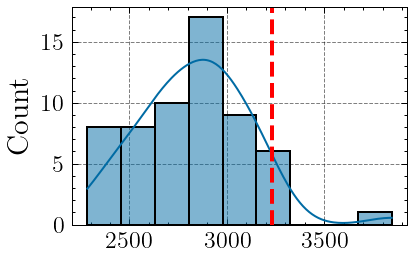

In [16]:
scores =df.scores.values
scores =np.vstack(scores).mean(1)
n = len(scores)
alpha = 0.05
q_hat = torch.quantile(torch.from_numpy(scores), (n+1)*(1-alpha)/n)
import seaborn as sns
fig, axes = plt.subplots(1,1, figsize =(3,2))
#axes = axes.ravel()
sns.histplot(x=scores, kde=True, ax=axes, color='C0', palette='tab10')
axes.axvline(q_hat, 0,20, color="red", ls='--', lw=2)

In [17]:
calibrated=np.where(scores<=q_hat.item())[0]
non_c =np.where(scores>q_hat.item())[0]
non_c

array([44, 45], dtype=int64)

In [18]:
bad_forecast=np.where(df['nrmse'].values==df['nrmse'].max())[0][0]
good_forecast=np.where(df['nrmse'].values==df['nrmse'].min())[0][0]


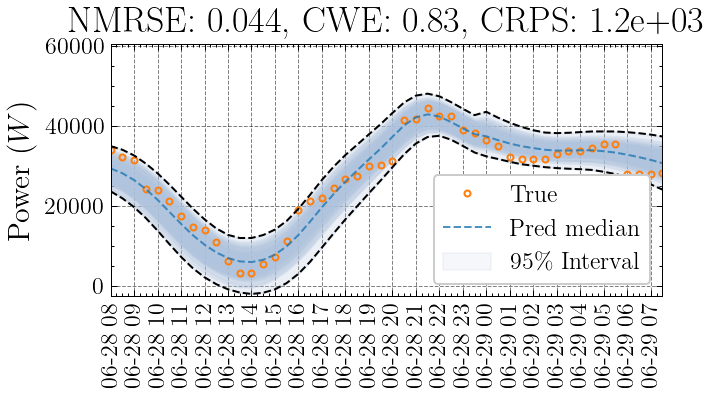

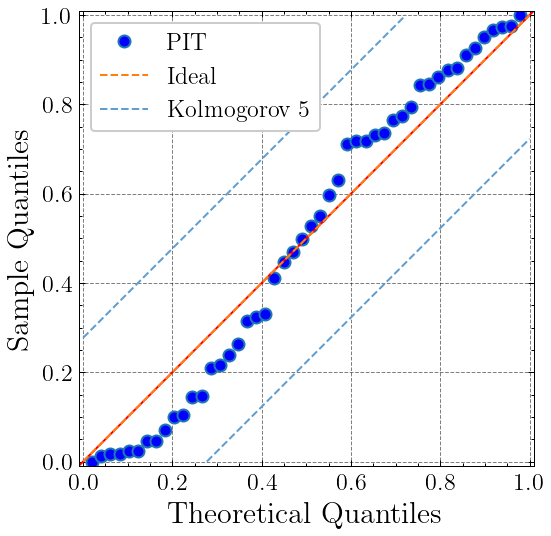

In [19]:
good_forecast=16
bad_forecast=48
i=good_forecast
mu, t, q_p, q=pred[i:i+48, 0].T, true[i:i+48, 0].T, q_pred[i:i+48,:, 0].T, tau[i:i+48,:, 0].T
l,l_25, u, u_75 = q_p[0], q_p[int(82*0.1)],  q_p[-1], q_p[int(82*0.965)]
std = (q_p*q).std(0).flatten()
fig, ax = plt.subplots(1, 1, figsize = (5,3.1))
ax=plot_prediction_with_pi(ax, t, mu, q_p, results['index'][i:i+48])
ax.plot(results['index'][i:i+48], l, 'k--')
ax.plot(results['index'][i:i+48], u, 'k--')
met=df[['nrmse', 'ciwe', 'qncrps']].iloc[i].values
ax.set_title("NMRSE: {:.2g}, CWE: {:.2g}, CRPS: {:.2g}%".format(met[0], met[1], met[2])); 
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
min_y=min(t.min(), l.min(), 0)-500
max_y=max(t.max(), u.max(), 60000)+500
ax.set_ylim(min_y, max_y)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()
fig.savefig(f"FPSe2Q_{encoder}_confidence_{i}_forecasted.pdf", dpi=480)



data=get_realibility_scores(t, q_p.T, q.T)
from statsmodels.graphics.api import qqplot          
cdf=stats.uniform
fig = plt.figure(figsize=(4.1,4.1))
axs = fig.add_subplot(111)
fig = qqplot(data, dist=cdf, line='45', ax=axs, color='#1f77b4', label="PIT")
deta = 1.358 / (len(data)) ** 0.5 * (2 ** 0.5)
lw=1
axs.plot([0, 1], [0, 1], "--", label="Ideal", c="#ff7f0e")   
axs.plot([deta, 1], [0, 1 - deta], '--', color='C4', lw=lw, label='Kolmogorov 5% significance band')
axs.plot([0, 1 - deta], [deta, 1], '--', color='C4', lw=lw)
axs.legend()
plt.axis("square")
buff = 0.01
plt.xlim([0 - buff, 1 + buff])
plt.ylim([0 - buff, 1 + buff])
fig.tight_layout()
fig.savefig(f"FPSe2Q_{encoder}_qqplot_{i}_forecasted.pdf", dpi=480)





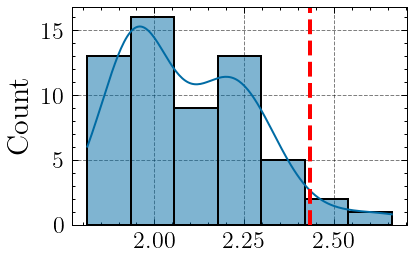

In [48]:
def get_model_uncertainity(mu, q_pred):
    return np.sqrt(np.square(q_pred-np.repeat(mu[:,None,:], q_pred.shape[1], axis=1)).mean(1))
uncert = []
for i in range(0, len(pred), 48):
    un=get_model_uncertainity(pred[i:i+48], q_pred[i:i+48,:])
    uncert.append(un.sum(0)/target_range)
    
uncert = np.vstack(uncert)    
n = len(uncert)
alpha = 0.05
q_hat = torch.quantile(torch.from_numpy(uncert.flatten()), (n+1)*(1-alpha)/n)
fig, axes = plt.subplots(1,1, figsize =(3,2))
#axes = axes.ravel()
sns.histplot(x=uncert.flatten(), kde=True, ax=axes, color='C0', palette='tab10')
axes.axvline(q_hat, 0,20, color="red", ls='--', lw=2)

In [49]:
calibrated=np.where(uncert<=q_hat.item())[0]
non_c =np.where(uncert>q_hat.item())[0]
non_c

array([38, 44], dtype=int64)

array([0.08030376, 0.8570672216405509, 2371.7072820737317], dtype=object)

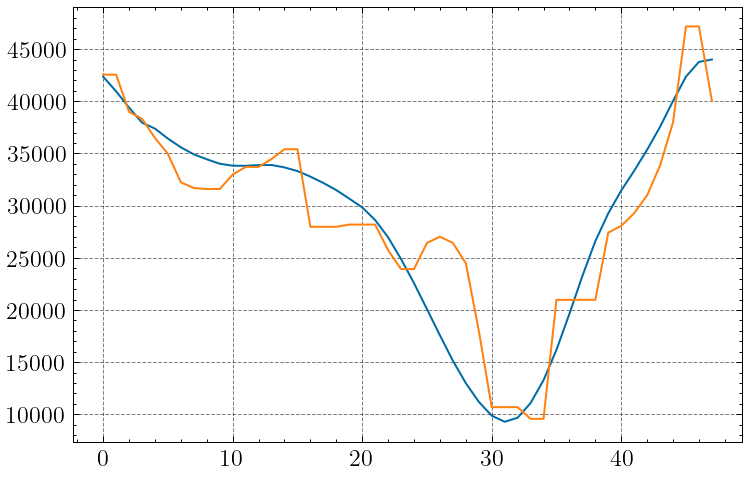

In [56]:
i=44
plt.plot(pred[i:i+48])
plt.plot(true[i:i+48])
met=results['metrics'][['nrmse', 'ciwe', 'qncrps']].iloc[i].values

met

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1,3, figsize =(12,4))
axes = axes.ravel()
sns.histplot(x=scores, kde=True, ax=axes[0], color='C0', palette='tab10')
axes[0].axvline(q_hat, 0,scores.max(), color="red", ls='--', lw=2)
sns.histplot(x=scores_1, kde=True, ax=axes[1], color='C1', palette='tab10')
axes[1].axvline(q_hat_1, 0,scores_1.max(), color="red", ls='--', lw=2)
sns.histplot(x=scores_2, kde=True, ax=axes[2], color='C5', palette='tab10')
axes[2].axvline(q_hat_2, 0,scores_2.max(), color="red", ls='--', lw=2)
fig.tight_layout()

In [ ]:
calibrated=np.where(scores<=q_hat.item())[0]
non_c =np.where(scores>q_hat.item())[0]
non_c

In [ ]:
def plot_uncert(ax, err, sigma, freq_in_bin=None, outlier_freq=0.0):
    if freq_in_bin is not None:
        freq_in_bin = freq_in_bin[torch.where(freq_in_bin > outlier_freq)]  # filter out zero frequencies
        err = err[torch.where(freq_in_bin > outlier_freq)]
        sigma = sigma[torch.where(freq_in_bin > outlier_freq)]
   
    max_val = np.max([err.max(), sigma.max()])
    min_val = np.min([err.min(), sigma.min()])
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.plot(sigma, err, marker='.')
    ax.set_ylabel(r'error')
    ax.set_xlabel(r'uncertainty')
    ax.set_aspect(1)
    
    return ax

In [ ]:
df=encoders_spilits['MLPEncoder'][1]

In [ ]:
np.square(mu-t).shape

In [ ]:
uncert = np.sqrt((q_p -mu)**2).mean(0)/target_range
errors  = np.sqrt((mu-t)**2)/target_range
n_bins = 15
bin_boundaries = np.linspace(uncert.min(), uncert.max(), n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
outlier=0.0
errors_in_bin_list = []
avg_uncert_in_bin_list = []
prop_in_bin_list = []
uce = np.zeros(1)

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (uncert>bin_lower) * (uncert<bin_upper)
    prop_in_bin = 1.0*in_bin.mean()  # |Bm| / n
    prop_in_bin_list.append(prop_in_bin)
    
    if prop_in_bin > outlier:
        errors_in_bin = errors[in_bin].mean()  # err()
        avg_uncert_in_bin = uncert[in_bin].mean()  # uncert()
        uce += np.abs(avg_uncert_in_bin - errors_in_bin) * prop_in_bin

        errors_in_bin_list.append(errors_in_bin)
        avg_uncert_in_bin_list.append(avg_uncert_in_bin)
        
err_in_bin = np.array(errors_in_bin_list)
avg_uncert_in_bin = np.array(avg_uncert_in_bin_list)
prop_in_bin = np.array(prop_in_bin_list)



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.25))
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax=plot_uncert(ax, err_in_bin, avg_uncert_in_bin, freq_in_bin=None, outlier_freq=0.0)
ax.set_title(r'Calibration Diagram')
textstr0 = f'UCE\,=\,{uce.item():.{3}f}'
ax.text(0.925, 0.075, textstr0, transform=ax.transAxes, fontsize=12,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=props
                )
fig.tight_layout()

In [6]:
results['target_range']

55536.758

In [7]:
data

NameError: name 'data' is not defined